# PSFs for the companions
The whole Cepheid project is focussed on the Cepheids PSF, fitting, subtracting etc. using LOCI and other complicated algorithms. However, in some cases, we also need a simple prescription of the PSF for "normal" stars, i.e. stars that are not saturated ant not insanly overexposed, so that we don't see the same number of structures in the wings that we do see for the Cepheids. In particualr, we need an analytic form of the PSF to fit the flux of any detected companions and similarly, we need a sample of "clean" stars that we can use for our fake-insert experiements to determine fit uncertianties and detection limits.

In this notebook, we stars from a list of hand-selected stars in the Cepheid images. I just clicked through the images in ds9, selecting all stars that had a flux in the central pixel > 200, are not visibly impacted by the Cepheid PSF (usually that means they are far away, but if a star is very bright, then it is OK if it's close to the diffraction spike as long as it's flux is much larger than the spike), are single and look circular (no unresolved binaries). 

In this notebook, we load in that list and then perform additional filtering to get a set of clean PSF templates.

In [ ]:
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy import table
from astropy.table import Table
from astropy.wcs import WCS
from astropy.io import fits

from astropy.nddata import NDData
from photutils.psf import extract_stars

import sherpa
import sherpa.astro.models
import sherpa.data
import sherpa.fit

import matplotlib.pyplot as plt

%matplotlib inline

In [105]:
# On melkor, the datapath is hardocded in snapshot program
# but to run on my laptop, I need to put it here
datapath = 'data/'

In [106]:
prflist = [['ibg402010_drz.fits', 612, 209],
           ['ibg402010_drz.fits', 1007, 951],
           ['ibg402010_drz.fits', 64, 823],
           ['ibg403010_drz.fits', 597, 385],
           ['ibg405010_drz.fits', 340, 40],
           ['ibg406010_drz.fits', 424, 348],
           ['ibg412010_drz.fits', 439, 239],
           ['ibg415010_drz.fits', 676, 73],
           ['ibg416010_drz.fits', 444, 217],
           ['ibg417010_drz.fits', 587, 954],
           ['ibg418010_drz.fits', 113, 946],
           ['ibg418010_drz.fits', 160, 720],
           ['ibg418010_drz.fits', 113, 946],
           ['ibg418010_drz.fits', 917, 873],
           ['ibg419010_drz.fits', 675, 644],
           ['ibg422010_drz.fits', 896, 320],
           ['ibg425010_drz.fits', 647, 697],
           ['ibg426010_drz.fits', 997, 84],
           ['ibg426010_drz.fits', 385, 95],
           ['ibg428010_drz.fits', 356, 85],
           ['ibg428010_drz.fits', 889, 496],
           ['ibg429010_drz.fits', 803, 305],
           ['ibg432010_drz.fits', 153, 109],
           ['ibg434010_drz.fits', 876, 577],
           ['ibg436010_drz.fits', 342, 878],
           ['ibg437010_drz.fits', 873, 239],
           ['ibg438010_drz.fits', 41, 651],
           ['ibg438010_drz.fits', 417, 403],
           ['ibg440010_drz.fits', 212, 338],
           ['ibg440010_drz.fits', 297, 1018],
           ['ibg443010_drz.fits', 358, 289],
           ['ibg444010_drz.fits', 329, 347],
           ['ibg444010_drz.fits', 724, 725],
           ['ibg446010_drz.fits', 276, 501],
           ['ibg449010_drz.fits', 75, 775],
           ['ibg450010_drz.fits', 669, 272],
           ['ibg452010_drz.fits', 158, 558],
           ['ibg453010_drz.fits', 812, 847],
           ['ibg453010_drz.fits', 333, 189],
           ['ibg455010_drz.fits', 567, 650],
           ['ibg455010_drz.fits', 263, 444],
           ['ibg456010_drz.fits', 530, 696],
           ['ibg458010_drz.fits', 162, 807],
           ['ibg459010_drz.fits', 375, 168],
           ['ibg462010_drz.fits', 683, 641],
           ['ibg463010_drz.fits', 647, 971],
           ['ibg463010_drz.fits', 319, 873],
           ['ibg465010_drz.fits', 588, 723],
           ['ibg468010_drz.fits', 150, 509],
           ['ibg468010_drz.fits', 280, 136],
           ['ibg471010_drz.fits', 600, 685],
           ['ibg471010_drz.fits', 892, 511],
          ]

First, we turn to GAIA. While the current DR2 does not explicitly mark catalog entries as multiple systems or extended sources, we can just look at the error in RA and dec. For stars as bright as the ones we've chosen, those errors are typically i nthe range 0.05 milliarcsec. Anything larger than that indicates that the source is not a good point source, so we want to reject it.

In [ ]:
radius = u.Quantity(1.0, u.arcsec)
gaia = []

for i, p in enumerate(prflist):
    wcs = WCS(fits.getheader(datapath + p[0], 1))
    ra, dec = wcs.all_pix2world(p[1], p[2], 1)
    coord = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree), frame='icrs')
    j = Gaia.cone_search(coord, radius)
    r = j.get_results()
    r['i'] = i
    r['file'] = p[0]
    r['x'] = p[1]
    r['y'] = p[2]
    gaia.append(r)

In [147]:
gaiatab = table.vstack(gaia)
gaiatab

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,dist,i,file,x,y
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,,,,,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object,float64,int64,str18,int64,int64
1635721458409799680,Gaia DR2 4267397694782220928,4267397694782220928,10069113,2015.5,287.0541433764063,0.05708831775288969,1.2965540270798912,0.05138955191992388,0.13894064229307077,0.06580436778492452,2.1114197,-3.5983806376683556,0.11716042079325267,-4.890581302399294,0.1060709894690015,-0.022343619,-0.16889304,0.10487678,-0.008879941,-0.1807251,0.020061811,-0.009888715,-0.14247748,0.09369423,0.10258331,94,0,93,1,6.1113224,195.38673,0.27571303985337103,7.144663158858341,31,False,9.288314,1.335154723024166,0.012888308203565471,0.010525897,11,8,0.11141969,0,11,False,93,26397.85635729691,35.62608108266079,740.97,14.634444,7,4945.669075549839,52.96075315978942,93.38366,16.115826,8,34249.82197614091,162.94872815050286,210.18773,13.425274,1.4847983,0,2.6905518,1.4813814,1.2091703,--,--,0,--,--,--,NOT_AVAILABLE,36.002315006993626,-3.1393248964273917,288.6661107417451,23.637494719974537,100001,3804.95,3232.3333,4116.15,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+4267397694782220928,,5.717718462157228e-05,0,ibg402010_drz.fits,612,209
1635721458409799680,Gaia DR2 4267397797861530112,4267397797861530112,154730446,2015.5,287.05620191976226,0.04636229294006126,1.3

In [148]:
# Select only those stars that are likely good single point sources
gaiatab = gaiatab[(gaiatab['ra_error'] < 0.1) & (gaiatab['dec_error'] < 0.1)]

Next, we load all remaining sources.

In [149]:
# -1 because the above positions are measured in ds9, which counts from (1,1)   
# while the python code counts from (0,0)                                       
stars621 = extract_stars([NDData(fits.open(datapath + row['file'])[1].data) for row in gaiatab],
                         [Table({'x': [row['x'] - 1], 'y': [row['y'] - 1]}) for row in gaiatab],
                         size=25)
stars845 = extract_stars([NDData(fits.open(datapath + row['file'].replace('10_', '20_'))[1].data) 
                          for row in gaiatab],
                         [Table({'x': [row['x'] - 1], 'y': [row['y'] - 1]}) for row in gaiatab],
                         size=25)


In [150]:
def sherpa_phot(psf, data):
    # Set sensible starting values
    # Use hasattr so I can use the same function for e.g. Gauss2D if I want to try that
    if hasattr(psf, 'alpha') and not psf.alpha.frozen:
        psf.alpha = 2
    if hasattr(psf, 'r0') and not psf.r0.frozen:
        psf.r0 = 2
    psf.ampl = np.max(s.data)
    x, y = np.indices(data.shape)
    dpsf = sherpa.data.Data2D('', x.flatten(), y.flatten(), data.flatten())
    fpsf = sherpa.fit.Fit(dpsf, psf, stat=sherpa.stats.LeastSq())
    fpsf.fit()
    return data - psf(x.flatten(), y.flatten()).reshape(data.shape)

In [151]:
beta2d = sherpa.astro.models.Beta2D()
beta2d.xpos = stars621[0].data.shape[0] / 2
beta2d.ypos = stars621[0].data.shape[1] / 2
beta2d.alpha = 2
beta2d.alpha.frozen = True

results = []

for i, s in enumerate(stars621):
    out = sherpa_phot(beta2d, s.data)
    results.append([p.val for p in beta2d.pars])
res621 = Table(rows=results, names = [p.name for p in beta2d.pars])

In [152]:
results = []

for i, s in enumerate(stars845):
    out = sherpa_phot(beta2d, s.data)
    results.append([p.val for p in beta2d.pars])
res845 = Table(rows=results, names = [p.name for p in beta2d.pars])

Since the (x,y) positions are just picked by hand in ds9, they might be off by a pixel or two. However, for the fake insertion technique later, we want sources that are reasonably centered in the extracted sub-images. Thus, in the first round, we fit the (x,y) values, calculate the difference and then adjust the input (x,y) in our catalog.

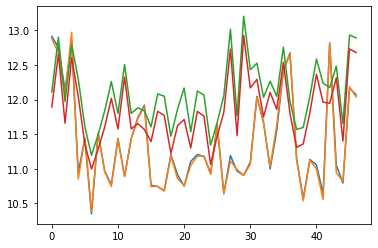

In [153]:
plt.plot(res621['xpos'])
plt.plot(res845['xpos'])
plt.plot(res621['ypos'])
plt.plot(res845['ypos'])

In [154]:
# Note how (x, y) -> (y, x) because of the ordering of the indices
# I don't want to find out exactly where that happens, just make make this line look better.
# I just chekc that it works (see below) and that's all that I need here.
gaiatab['x'] = gaiatab['x'] - np.rint(12.5 - res621['ypos'])
gaiatab['y'] = gaiatab['y'] - np.rint(12.5 - res621['xpos'])

In [155]:
# Now extract it again
# -1 because the above positions are measured in ds9, which counts from (1,1)   
# while the python code counts from (0,0)                                       
stars621 = extract_stars([NDData(fits.open(datapath + row['file'])[1].data) for row in gaiatab],
                         [Table({'x': [row['x'] - 1], 'y': [row['y'] - 1]}) for row in gaiatab],
                         size=25)
stars845 = extract_stars([NDData(fits.open(datapath + row['file'].replace('10_', '20_'))[1].data) 
                          for row in gaiatab],
                         [Table({'x': [row['x'] - 1], 'y': [row['y'] - 1]}) for row in gaiatab],
                         size=25)


In [188]:
# fit it again
results = []

for i, s in enumerate(stars621):
    beta2d.xpos = 12.5
    beta2d.ypos = 12.5
    out = sherpa_phot(beta2d, s.data)
    results.append([p.val for p in beta2d.pars])
res621 = Table(rows=results, names = [p.name for p in beta2d.pars])

results = []

for i, s in enumerate(stars845):
    beta2d.xpos = 12.5
    beta2d.ypos = 12.5
    out = sherpa_phot(beta2d, s.data)
    results.append([p.val for p in beta2d.pars])
res845 = Table(rows=results, names = [p.name for p in beta2d.pars])

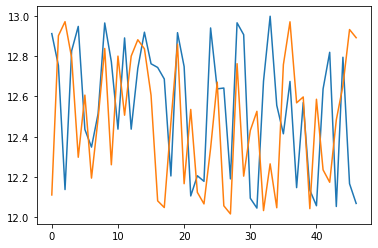

In [158]:
# Check its centered
plt.plot(res621['xpos'])
plt.plot(res845['xpos'])
plt.plot(res621['ypos'])
plt.plot(res845['ypos'])

### Look at fit results with alpha and r0 free

In [183]:
beta2d.alpha.frozen = False
results = []

for i, s in enumerate(stars621):
    beta2d.xpos = 12.5
    beta2d.ypos = 12.5
    out = sherpa_phot(beta2d, s.data)
    results.append([p.val for p in beta2d.pars])
res621ar = Table(rows=results, names = [p.name for p in beta2d.pars])

results = []

for i, s in enumerate(stars845):
    beta2d.xpos = 12.5
    beta2d.ypos = 12.5
    out = sherpa_phot(beta2d, s.data)
    results.append([p.val for p in beta2d.pars])
res845ar = Table(rows=results, names = [p.name for p in beta2d.pars])

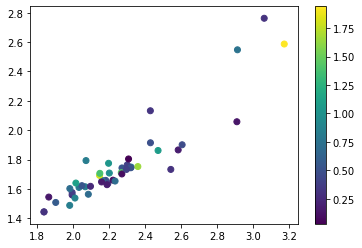

In [185]:
plt.scatter(res621ar['alpha'], res621ar['r0'], c=gaiatab['parallax'])
plt.colorbar()

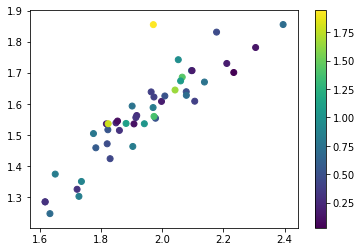

In [186]:
plt.scatter(res845ar['alpha'], res845ar['r0'], c=gaiatab['parallax'])
plt.colorbar()

### Look at fit results when alpha is frozen
Even if the alpha is frozen to a differnet value then what I will ultimately use to fit the LOCI subtracted data, it's close enough. The goal here is to remove source that obviously have a different PSF shape, e.g. because they are unresolved binaries or background sources or something.

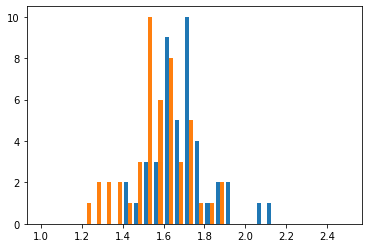

In [198]:
out = plt.hist([res621['r0'], res845['r0']], bins=np.arange(1., 2.51, .05))

In [224]:
ind = (np.abs(res621['r0'] - 1.65) < .4) & (np.abs(res845['r0'] - 1.6) < 0.4)

In [226]:
ind.sum(), len(res621)

(42, 47)

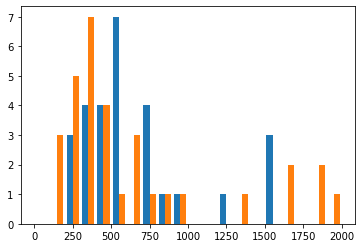

In [204]:
out = plt.hist([res621['ampl'][ind], res845['ampl'][ind]], bins=20, range=[0,2000])

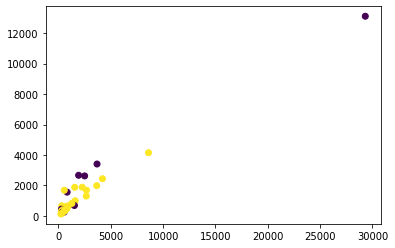

In [202]:
plt.scatter(res621['ampl'], res845['ampl'], c=ind)

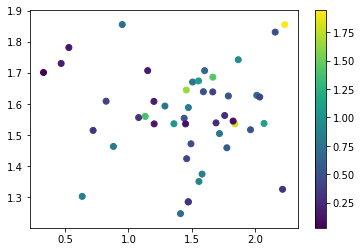

In [203]:
plt.scatter(res621['ampl'] / res845['ampl'], res845['r0'], c=gaiatab['parallax'])
plt.colorbar()

In [177]:
psf_621 = sherpa.astro.models.Beta2D()
psf_621.alpha = 2.2
psf_621.r0 = 1.7

psf_845 = sherpa.astro.models.Beta2D()
psf_845.alpha = 2
psf_845.r0 = 1.625

for this_psf in [psf_621, psf_845]:
    # Set starting values
    this_psf.xpos = 12.5
    this_psf.ypos = 12.5
    # Freeze psf values
    this_psf.alpha.frozen = True
    this_psf.r0.frozen = True
    

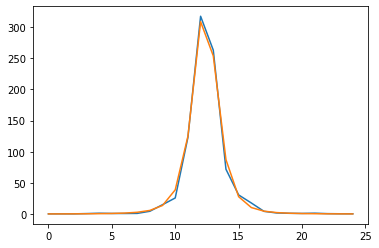

In [181]:
data = stars845[5].data
plt.plot(data[12, :])

psf_845.ampl = np.max(data)
x, y = np.indices(data.shape)
dpsf = sherpa.data.Data2D('', x.flatten(), y.flatten(), data.flatten())
fpsf = sherpa.fit.Fit(dpsf, psf_845, stat=sherpa.stats.LeastSq())
fpsf.fit()
plt.plot(psf_845(x.flatten(), y.flatten()).reshape(data.shape)[12, :])

## Select the PSF stars
These stars have the following cuts applied:

- Look good in GAIA
- Have typical r0 fit results (for fixed alpha)
- pick the brightest of those

In [217]:
bright = (res621['ampl'] > 400) & (res845['ampl'] > 400)

In [227]:
(ind & bright).sum()

23

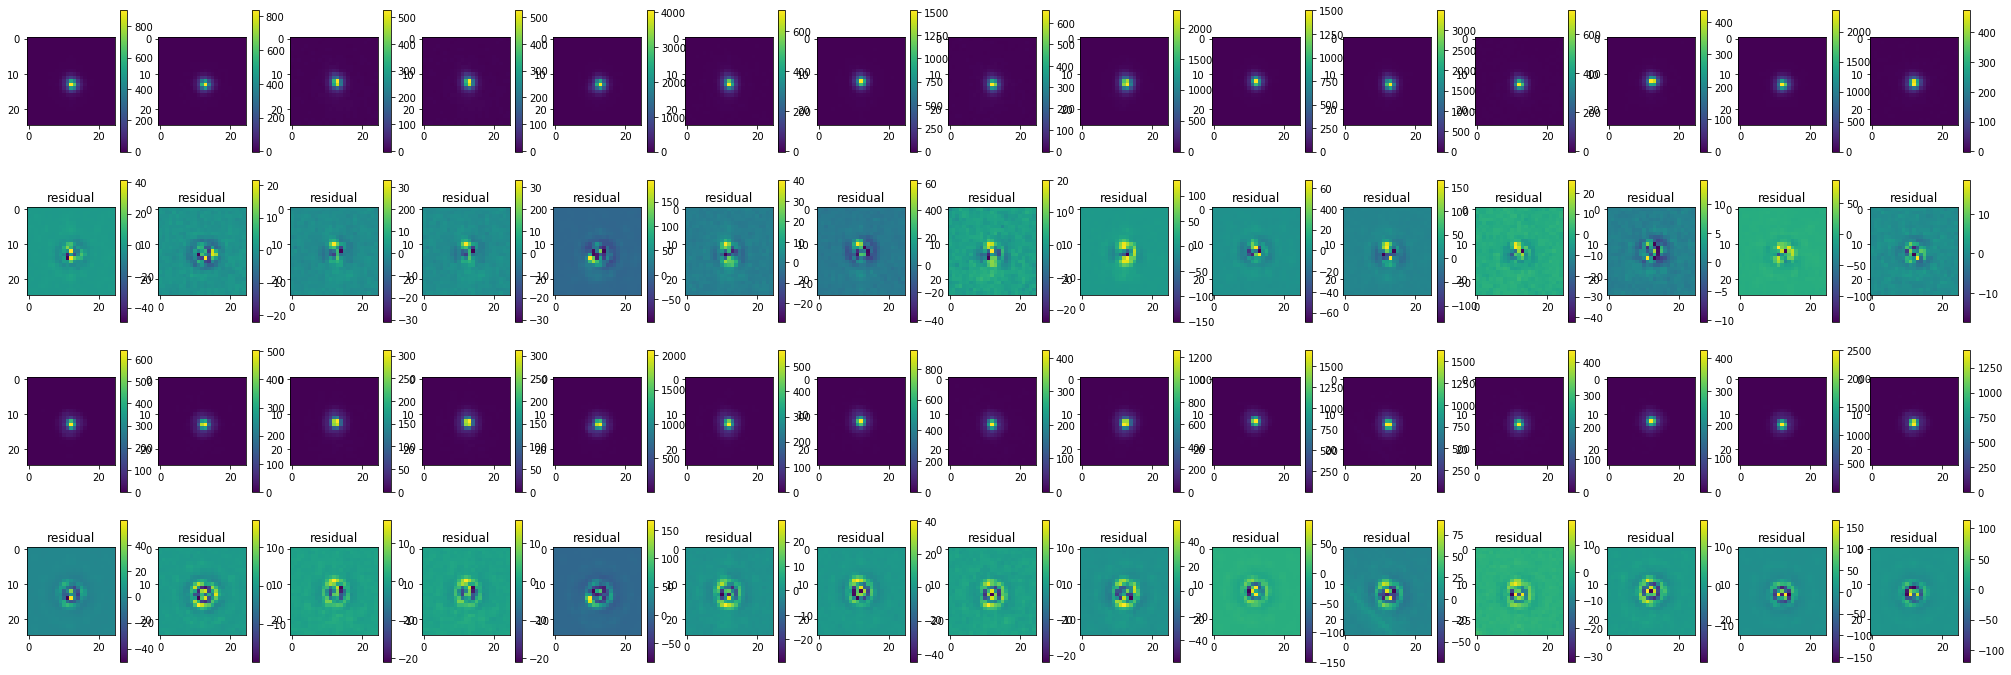

In [228]:
x, y = np.indices(stars621[0].data.shape)

fig, axes = plt.subplots(nrows=4, ncols=15, figsize=(35,12))

for j, s in enumerate((ind & bright).nonzero()[0][:15]):
    for i, stars in enumerate([stars621, stars845]):
        image = stars[s].data
        imout = axes[2 * i][j].imshow(image)
        #axes[0][j].set_title(prftestlist[j][0])
        plt.colorbar(imout, ax = axes[2 * i][j])
        thispsf = [psf_621, psf_845][i]
        photout = sherpa_phot(thispsf, image)
        imout = axes[2 * i + 1][j].imshow(photout)
        axes[2 * i + 1][j].set_title("residual")
        plt.colorbar(imout, ax = axes[2 * i + 1][j])

In [229]:
len(gaiatab), len(bright)

(47, 47)

In [234]:
for row in gaiatab[ind & bright]:
    print("['{}', {:3.0f}, {:3.0f}],".format(row['file'], row['x'], row['y']))

['ibg405010_drz.fits', 340,  38],
['ibg416010_drz.fits', 443, 215],
['ibg418010_drz.fits', 112, 945],
['ibg418010_drz.fits', 112, 945],
['ibg422010_drz.fits', 895, 319],
['ibg426010_drz.fits', 385,  93],
['ibg436010_drz.fits', 342, 877],
['ibg438010_drz.fits', 416, 401],
['ibg440010_drz.fits', 211, 337],
['ibg443010_drz.fits', 359, 288],
['ibg444010_drz.fits', 328, 345],
['ibg444010_drz.fits', 725, 723],
['ibg446010_drz.fits', 276, 500],
['ibg453010_drz.fits', 812, 845],
['ibg453010_drz.fits', 333, 188],
['ibg455010_drz.fits', 263, 444],
['ibg456010_drz.fits', 529, 696],
['ibg458010_drz.fits', 161, 806],
['ibg459010_drz.fits', 374, 166],
['ibg465010_drz.fits', 588, 723],
['ibg468010_drz.fits', 150, 508],
['ibg471010_drz.fits', 600, 685],
['ibg471010_drz.fits', 892, 511],


The output of this notebook is this list of good PSF stars in the form of a python list with filename, x, and y of the position. The cleanest form of using this woudl be to write it out to a datatable. Any function that needs PSFs could than load any version of that table that we want. However, the way the code is currently written, this list is simply copied into the source code of `detection.py` in the `snapshotprogram` code. It's a little hacky, but it serves the same purpose and I really don't see why I should spend time ot clean this up right now. If I were to do a similar program again, I might use a different approach anyway.